In [1]:
# Import the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import the required datasets
calendar = pd.read_csv('C://Users/allan.abraham/Downloads/SeattleAirbnb/calendar.csv')
listings = pd.read_csv('C://Users/allan.abraham/Downloads/SeattleAirbnb/listings.csv')
reviews = pd.read_csv('C://Users/allan.abraham/Downloads/SeattleAirbnb/reviews.csv')

# Business Problem

- Is the price of an AirBnb dependent on the number of ammenties provided?
- Is the price of an AirBnb dependent on the number of bedrooms and bathrooms?
- Is the price of an AirBnb dependent on its previous ratings?
- Can the sentiment of the users be predicted based on the AirBnb they have chosen (if they are likely to enjoy their stay or not)?

# Data Understanding and Preparation

Filtering out just the available AirBnbs and checking the non null columns

In [3]:
available_calendar = calendar[calendar['available']=='t']

In [4]:
available_calendar.columns[available_calendar.isnull().mean()==0]

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

Converting price to float

In [5]:
available_calendar['price'] = available_calendar['price'].str.replace('$', '').astype(str)
available_calendar['price'] = available_calendar['price'].str.replace(',', '').astype(float)

C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_14272/334025636.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  available_calendar['price'] = available_calendar['price'].str.replace('$', '').astype(str)
C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_14272/334025636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  available_calendar['price'] = available_calendar['price'].str.replace('$', '').astype(str)
C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_14272/334025636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Getting oldest and newest prices for a listing to check if there is a change in pricing

In [6]:
idx = available_calendar.groupby(['listing_id'])['date'].transform(max) == available_calendar['date']
newest = available_calendar[idx]

In [7]:
ids = available_calendar.groupby(['listing_id'])['date'].transform(min) == available_calendar['date']
oldest = available_calendar[ids]

In [8]:
calendar_final = pd.merge(oldest, newest, on="listing_id")
calendar_final['diff'] = calendar_final['price_y'] - calendar_final['price_x']
calendar_final.drop(['date_x','date_y','price_x','price_y','available_x','available_y'],axis=1,inplace=True)
calendar_final

,listing_id,diff
0,241032,0.0
1,953595,275.0
2,3308979,0.0
3,7421966,0.0
4,278830,-150.0
...,...,...
3718,8101950,0.0
3719,8902327,27.0
3720,10267360,-18.0
3721,9604740,0.0


In [40]:
listings.columns[listings.isnull().mean()>0.75]

Index(['square_feet', 'license'], dtype='object')

Since these values have over 75% null values we would not be considering them. Even though sqaure feet is a good fit that can help improve our model, we would not be opting for it.

In [9]:
def assign_price_change_score(k):
    """
    Description:
    Assign price score based on the change in price for an Airbnb
    
    Returns:
    int
    """
    if k > 0:
        return 1
    elif k < 0:
        return -1
    else:
        return 0

In [10]:
#Assign a score for change in price
calendar_final['price_score'] = calendar_final['diff'].apply(assign_price_change_score)
calendar_final

,listing_id,diff,price_score
0,241032,0.0,0
1,953595,275.0,1
2,3308979,0.0,0
3,7421966,0.0,0
4,278830,-150.0,-1
...,...,...,...
3718,8101950,0.0,0
3719,8902327,27.0,1
3720,10267360,-18.0,-1
3721,9604740,0.0,0


Sentiment Analysis

In [11]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\allan.abraham\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allan.abraham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
reviews["row_id"] = reviews.index + 1

In [13]:
#create a new data frame with "id" and "comment" fields
df_subset = reviews[['row_id','listing_id','comments']].copy()
#data clean-up
#remove all non-aphabet characters
df_subset['Response'] = df_subset['comments'].str.replace("[^a-zA-Z#]", " ")
#covert to lower-case
df_subset['Response'] = df_subset['Response'].str.casefold()
print (df_subset.head(10))

C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_14272/3820795433.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_subset['Response'] = df_subset['comments'].str.replace("[^a-zA-Z#]", " ")


   row_id  listing_id                                           comments  \
0       1     7202016  Cute and cozy place. Perfect location to every...   
1       2     7202016  Kelly has a great room in a very central locat...   
2       3     7202016  Very spacious apartment, and in a great neighb...   
3       4     7202016  Close to Seattle Center and all it has to offe...   
4       5     7202016  Kelly was a great host and very accommodating ...   
5       6     7202016  Kelly was great, place was great, just what I ...   
6       7     7202016  Kelly was great! Very nice and the neighborhoo...   
7       8     7202016  hola all bnb erz - Just left Seattle where I h...   
8       9     7202016  Kelly's place is conveniently located on a qui...   
9      10     7202016  The place was really nice, clean, and the most...   

                                            Response  
0  cute and cozy place  perfect location to every...  
1  kelly has a great room in a very central locat... 

In [14]:
## Change the reviews type to string
df_subset['reviews.text'] = df_subset['Response'].astype(str)

## Lowercase all reviews
df_subset['reviews.text'] = df_subset['reviews.text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [15]:
#Stop-words being most commonly used in the English language; however, these words have no predictive power in reality. Words such as I, me, myself, he, she, they, our, mine, you, yours etc.
stop = stopwords.words('english')
df_subset['reviews.text'] = df_subset['reviews.text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [16]:
# Stemming algorithm is very useful in the field of text mining and helps to gain relevant information as it reduces all words with the same roots to a common form by removing suffixes such as -action, ing, -es and -ses. However, there can be problematic where there are spelling errors.
st = PorterStemmer()
df_subset['reviews.text'] = df_subset['reviews.text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [17]:
def senti(x):
    """
    Description
    Get the sentiment from the text using inbuilt function
    
    Return
    polairty and subjectivity score (float,float)
    """
    return TextBlob(x).sentiment  

df_subset['senti_score'] = df_subset['reviews.text'].apply(senti)

df_subset.senti_score.head()

0                                  (0.75, 1.0)
1    (0.22321428571428573, 0.4928571428571429)
2                                 (0.7, 0.825)
3                                 (0.25, 0.35)
4     (0.5148148148148148, 0.5518518518518518)
Name: senti_score, dtype: object

In [18]:
df_subset['polarity'] = df_subset['senti_score'].str.get(0)
df_subset['subjectivity'] = df_subset['senti_score'].str.get(1)

In [19]:
sentiment = pd.DataFrame(df_subset.groupby('listing_id').mean()).reset_index()
sentiment.drop('row_id', axis=1, inplace=True)

Converting categorical sentiments to integer values

In [20]:
def assign_sentiment_score(k):
    """
    Description:
    Assign sentiment score based on polarity
    
    Returns:
    int
    """
    if k > 0.5:
        return 1
    elif k <= 0:
        return -1
    else:
        return 0

In [21]:
#Assign a Sentiment based score to be used as one of the features for classifying
sentiment['pol_score'] = sentiment['polarity'].apply(assign_sentiment_score)
sentiment

,listing_id,polarity,subjectivity,pol_score
0,4291,0.384495,0.550949,0
1,5682,0.411016,0.610605,0
2,6606,0.377434,0.569910,0
3,7369,0.448791,0.592173,0
4,9419,0.325456,0.510719,0
...,...,...,...,...
3186,9995551,0.588889,0.816667,1
3187,10012724,0.225000,0.516667,0
3188,10020221,0.200000,0.655556,0
3189,10118341,0.400000,0.616270,0


In [22]:
#selecting the relevant features
listings_filt = listings[['id','city','state','zipcode','bathrooms','bedrooms','beds','price','amenities','review_scores_value','review_scores_rating','reviews_per_month']]
listings_filt

,id,city,state,zipcode,bathrooms,bedrooms,beds,price,amenities,review_scores_value,review_scores_rating,reviews_per_month
0,241032,Seattle,WA,98119,1.0,1.0,1.0,$85.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,95.0,4.07
1,953595,Seattle,WA,98119,1.0,1.0,1.0,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",10.0,96.0,1.48
2,3308979,Seattle,WA,98119,4.5,5.0,7.0,$975.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,97.0,1.15
3,7421966,Seattle,WA,98119,1.0,0.0,2.0,$100.00,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,NaN,NaN
4,278830,Seattle,WA,98119,2.0,3.0,3.0,$450.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",9.0,92.0,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,Seattle,WA,98107,2.0,3.0,3.0,$359.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,80.0,0.30
3814,8902327,Seattle,WA,98102,1.0,1.0,2.0,$79.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",10.0,100.0,2.00
3815,10267360,Seattle,WA,98178,1.0,1.0,1.0,$93.00,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ...",NaN,NaN,NaN
3816,9604740,Seattle,WA,98112,1.0,0.0,1.0,$99.00,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,NaN,NaN


In [23]:
listings_filt = listings_filt.dropna(subset=['id','city','state','zipcode','bathrooms','bedrooms','beds','price','amenities','review_scores_value','review_scores_rating','reviews_per_month'],how='any')
listings_filt['listing_id'] = listings_filt['id']
#Dropping id as it is just an identifier
listings_filt.drop('id',axis=1,inplace=True)
listings_filt

C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_14272/1625878398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_filt['listing_id'] = listings_filt['id']
C:\Users\allan.abraham\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,city,state,zipcode,bathrooms,bedrooms,beds,price,amenities,review_scores_value,review_scores_rating,reviews_per_month,listing_id
0,Seattle,WA,98119,1.0,1.0,1.0,$85.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,95.0,4.07,241032
1,Seattle,WA,98119,1.0,1.0,1.0,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",10.0,96.0,1.48,953595
2,Seattle,WA,98119,4.5,5.0,7.0,$975.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,97.0,1.15,3308979
4,Seattle,WA,98119,2.0,3.0,3.0,$450.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",9.0,92.0,0.89,278830
5,Seattle,WA,98119,1.0,1.0,1.0,$120.00,"{""Wireless Internet"",""Free Parking on Premises...",10.0,95.0,2.45,5956968
...,...,...,...,...,...,...,...,...,...,...,...,...
3810,Seattle,WA,98103,1.0,2.0,3.0,$154.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",8.0,92.0,1.56,262764
3811,Seattle,WA,98103,1.0,1.0,1.0,$65.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,100.0,0.63,8578490
3812,Seattle,WA,98107,1.0,1.0,2.0,$95.00,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",10.0,96.0,4.01,3383329
3813,Seattle,WA,98107,2.0,3.0,3.0,$359.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,80.0,0.30,8101950


In [24]:
list_sent = pd.merge(listings_filt, sentiment, on="listing_id")
#dropping polarity and subjectivity as it is has been converted to a score
list_sent.drop(['polarity','subjectivity'],axis=1,inplace=True)
list_sent

,city,state,zipcode,bathrooms,bedrooms,beds,price,amenities,review_scores_value,review_scores_rating,reviews_per_month,listing_id,pol_score
0,Seattle,WA,98119,1.0,1.0,1.0,$85.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,95.0,4.07,241032,0
1,Seattle,WA,98119,1.0,1.0,1.0,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",10.0,96.0,1.48,953595,0
2,Seattle,WA,98119,4.5,5.0,7.0,$975.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,97.0,1.15,3308979,0
3,Seattle,WA,98119,2.0,3.0,3.0,$450.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",9.0,92.0,0.89,278830,0
4,Seattle,WA,98119,1.0,1.0,1.0,$120.00,"{""Wireless Internet"",""Free Parking on Premises...",10.0,95.0,2.45,5956968,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,Seattle,WA,98103,1.0,2.0,3.0,$154.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",8.0,92.0,1.56,262764,0
3134,Seattle,WA,98103,1.0,1.0,1.0,$65.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,100.0,0.63,8578490,0
3135,Seattle,WA,98107,1.0,1.0,2.0,$95.00,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",10.0,96.0,4.01,3383329,0
3136,Seattle,WA,98107,2.0,3.0,3.0,$359.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,80.0,0.30,8101950,-1


In [25]:
df_final = pd.merge(list_sent,calendar_final,on="listing_id")
#dropping difference and price as this has been converted to a score
df_final.drop(['diff'],axis=1,inplace=True)
df_final['price'] = df_final['price'].str.replace('$', '').astype(str)
df_final['price'] = df_final['price'].str.replace(',', '').astype(float)
df_final

C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_14272/3309470438.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_final['price'] = df_final['price'].str.replace('$', '').astype(str)


,city,state,zipcode,bathrooms,bedrooms,beds,price,amenities,review_scores_value,review_scores_rating,reviews_per_month,listing_id,pol_score,price_score
0,Seattle,WA,98119,1.0,1.0,1.0,85.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,95.0,4.07,241032,0,0
1,Seattle,WA,98119,1.0,1.0,1.0,150.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",10.0,96.0,1.48,953595,0,1
2,Seattle,WA,98119,4.5,5.0,7.0,975.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,97.0,1.15,3308979,0,0
3,Seattle,WA,98119,2.0,3.0,3.0,450.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",9.0,92.0,0.89,278830,0,-1
4,Seattle,WA,98119,1.0,1.0,1.0,120.0,"{""Wireless Internet"",""Free Parking on Premises...",10.0,95.0,2.45,5956968,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,Seattle,WA,98103,1.0,2.0,3.0,154.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",8.0,92.0,1.56,262764,0,1
3064,Seattle,WA,98103,1.0,1.0,1.0,65.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,100.0,0.63,8578490,0,1
3065,Seattle,WA,98107,1.0,1.0,2.0,95.0,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",10.0,96.0,4.01,3383329,0,0
3066,Seattle,WA,98107,2.0,3.0,3.0,359.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,80.0,0.30,8101950,-1,0


In [26]:
df_final['amenities_count'] = df_final.amenities.str.count(',') + 1
# dropping ammenities as it has been converted to counts
df_final.drop('amenities',axis=1,inplace=True)
df_final

,city,state,zipcode,bathrooms,bedrooms,beds,price,review_scores_value,review_scores_rating,reviews_per_month,listing_id,pol_score,price_score,amenities_count
0,Seattle,WA,98119,1.0,1.0,1.0,85.0,10.0,95.0,4.07,241032,0,0,10
1,Seattle,WA,98119,1.0,1.0,1.0,150.0,10.0,96.0,1.48,953595,0,1,16
2,Seattle,WA,98119,4.5,5.0,7.0,975.0,10.0,97.0,1.15,3308979,0,0,21
3,Seattle,WA,98119,2.0,3.0,3.0,450.0,9.0,92.0,0.89,278830,0,-1,13
4,Seattle,WA,98119,1.0,1.0,1.0,120.0,10.0,95.0,2.45,5956968,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,Seattle,WA,98103,1.0,2.0,3.0,154.0,8.0,92.0,1.56,262764,0,1,22
3064,Seattle,WA,98103,1.0,1.0,1.0,65.0,10.0,100.0,0.63,8578490,0,1,15
3065,Seattle,WA,98107,1.0,1.0,2.0,95.0,10.0,96.0,4.01,3383329,0,0,19
3066,Seattle,WA,98107,2.0,3.0,3.0,359.0,8.0,80.0,0.30,8101950,-1,0,16


Create the final dataframe and drop non numerics

In [27]:
df_final_new = df_final.select_dtypes(include=['int','float'])
df_final_new

,bathrooms,bedrooms,beds,price,review_scores_value,review_scores_rating,reviews_per_month,listing_id,pol_score,price_score,amenities_count
0,1.0,1.0,1.0,85.0,10.0,95.0,4.07,241032,0,0,10
1,1.0,1.0,1.0,150.0,10.0,96.0,1.48,953595,0,1,16
2,4.5,5.0,7.0,975.0,10.0,97.0,1.15,3308979,0,0,21
3,2.0,3.0,3.0,450.0,9.0,92.0,0.89,278830,0,-1,13
4,1.0,1.0,1.0,120.0,10.0,95.0,2.45,5956968,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...
3063,1.0,2.0,3.0,154.0,8.0,92.0,1.56,262764,0,1,22
3064,1.0,1.0,1.0,65.0,10.0,100.0,0.63,8578490,0,1,15
3065,1.0,1.0,2.0,95.0,10.0,96.0,4.01,3383329,0,0,19
3066,2.0,3.0,3.0,359.0,8.0,80.0,0.30,8101950,-1,0,16


# Modelling

Apply Logistic Regression

In [28]:
X = df_final_new.drop(['pol_score'],axis=1)
y = df_final_new['pol_score']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [30]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\Users\allan.abraham\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
predictions = logmodel.predict(X_test)

Here we tried to predict the sentiment received by an airbnb based on price change (gone up, down or hasn't changed), facilities provided, ammenities and ratings

Analysis

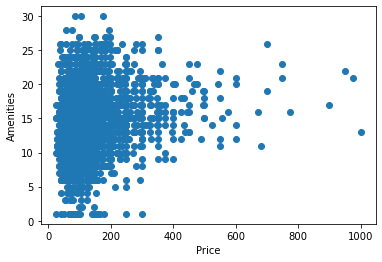

In [32]:
x = df_final_new.price
y = df_final_new.amenities_count

plt.scatter(x, y)
plt.ylabel('Amenities')
plt.xlabel('Price')
plt.show()

The Price of an Airbnb doesn't change much with the amenities provided. This indicates that the customer eligible for the maximum facility even at cheaper prices

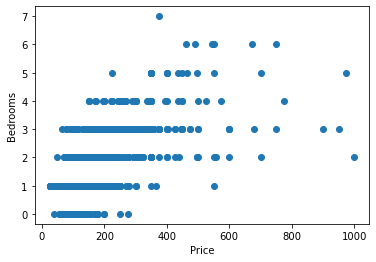

In [33]:
x = df_final_new.price
y = df_final_new.bedrooms

plt.scatter(x, y)
plt.ylabel('Bedrooms')
plt.xlabel('Price')
plt.show()

Even though the data is noisy, the price seems to increase with the number of bedrooms

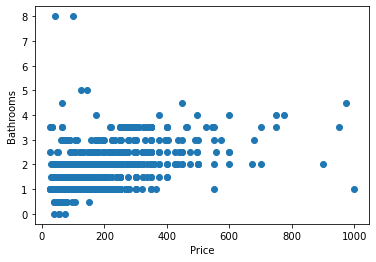

In [34]:
x = df_final_new.price
y = df_final_new.bathrooms

plt.scatter(x, y)
plt.ylabel('Bathrooms')
plt.xlabel('Price')
plt.show()

The price of an AirBnb does increase with the number of bathrooms

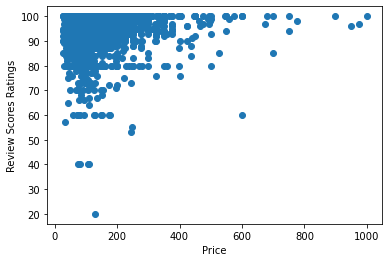

In [35]:
x = df_final_new.price
y = df_final_new.review_scores_rating

plt.scatter(x, y)
plt.ylabel('Review Scores Ratings')
plt.xlabel('Price')
plt.show()

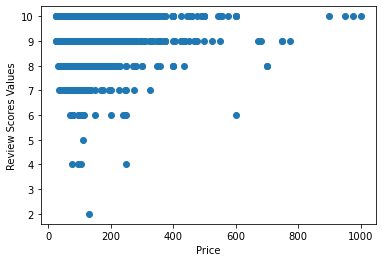

In [43]:
x = df_final_new.price
y = df_final_new.review_scores_value

plt.scatter(x, y)
plt.ylabel('Review Scores Values')
plt.xlabel('Price')
plt.show()

The ratings have been decent in general across the price band. For the cheaper Airbnbs (under 500), even though there are quite a few low ratings, the positive ratings (8+) outweigh the negatives largely

In [38]:
df_final.bedrooms.value_counts()*100/df_final.shape[0]

1.0    63.917862
2.0    16.786180
0.0     9.843546
3.0     7.268579
4.0     1.434159
5.0     0.521512
6.0     0.195567
7.0     0.032595
Name: bedrooms, dtype: float64

In [39]:
df_final.beds.value_counts()*100/df_final.shape[0]

1.0     57.790091
2.0     23.663625
3.0     11.571056
4.0      3.911343
5.0      1.792699
6.0      0.488918
7.0      0.456323
8.0      0.130378
9.0      0.097784
10.0     0.065189
15.0     0.032595
Name: beds, dtype: float64

Over 63% customers opted for a single bedroom and amongst then a whooping 58% opted for a single bed

# Evaluation

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         3
           0       0.91      1.00      0.95       842
           1       0.00      0.00      0.00        76

    accuracy                           0.91       921
   macro avg       0.30      0.33      0.32       921
weighted avg       0.84      0.91      0.87       921



C:\Users\allan.abraham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allan.abraham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allan.abraham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
